In [2]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from src.datasets.loading import statcan, ookla

In [48]:
import seaborn as sns

In [4]:
speed_tiles = ookla.canada_speed_tiles().loc[lambda s:(s.quarter==1) & (s.year==2022)]
speed_tiles.head()

,quadkey,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,conn_type,year,quarter
12,302303331012303,"POLYGON ((-73.36121 45.53329, -73.35571 45.533...",263271,40226,12,7,5,fixed,2022,1
31,212122230130321,"POLYGON ((-122.75574 49.30364, -122.75024 49.3...",222178,158924,8,117,39,fixed,2022,1
38,212122230130321,"POLYGON ((-122.75574 49.30364, -122.75024 49.3...",120847,23082,17,6,1,mobile,2022,1
54,212102012132221,"POLYGON ((-122.77771 53.85901, -122.77222 53.8...",174225,162880,14,5,4,fixed,2022,1
70,212122232013120,"POLYGON ((-122.89307 49.11703, -122.88757 49.1...",238545,162836,8,25,12,fixed,2022,1


In [30]:
#plot to see the download and upload speeds for fixed and mobile connections

speed_conn=speed_tiles.groupby('conn_type').mean()

speed_conn


/tmp/ipykernel_6258/72621527.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  speed_conn=speed_tiles.groupby('conn_type').mean()


,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,quarter
conn_type,,,,,,,,
fixed,2.697921e+14,134660.818513,52501.922181,33.473236,15.368857,4.362025,2022.0,1.0
mobile,2.715219e+14,91625.130516,15673.283032,34.491793,3.494698,1.542077,2022.0,1.0


TypeError: float() argument must be a string or a real number, not 'Polygon'

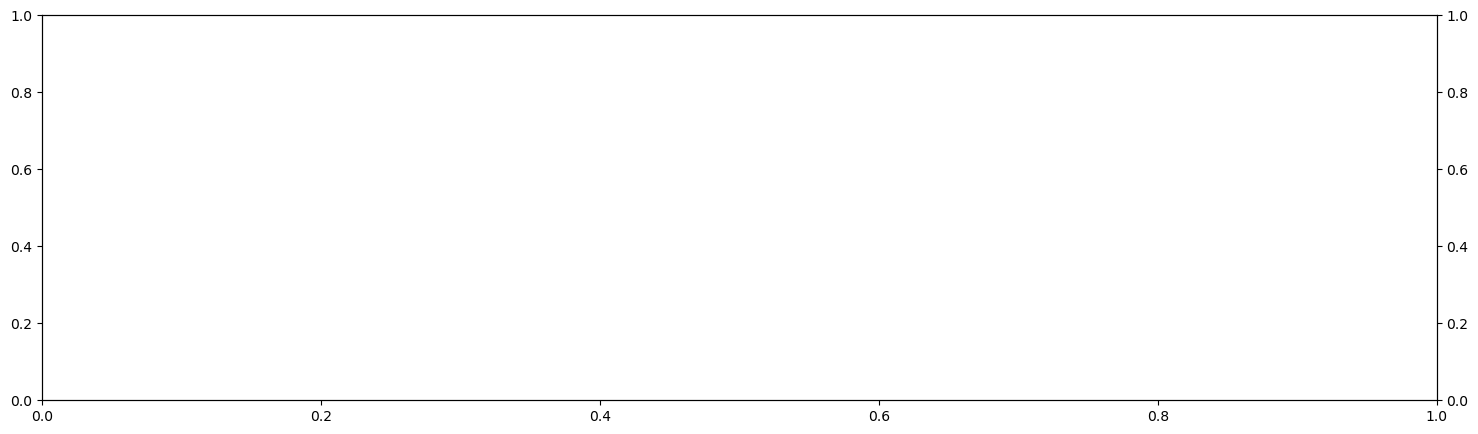

In [37]:
sns.catplot(y='conn_type', x='avg_d_kbps', data=)


In [38]:
statcan.boundary_names()

['provinces',
 'provinces_digital',
 'federal_electoral_districts_2013_representation_order',
 'economic_regions',
 'census_divisions',
 'population_centres',
 'population_ecumene',
 'dissemination_areas',
 'dissemination_blocks',
 'census_subdivisions',
 'designated_places',
 'lakes_and_rivers_polygons']

In [39]:
#Use a buffer to increase Red Deer size, envelope creates a bounding box for use later.
reddeer_area = statcan.boundary('population_centres').loc[lambda s:s.PCNAME=='Red Deer'].copy()
reddeer_area.geometry = reddeer_area.buffer(50000).envelope #The StatCan CRS is in units of meters, so this is all tiles within 50 km of Calgary

In [40]:
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(reddeer_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(3)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,PCNAME,PCTYPE,PCCLASS
3992,4805031,Starland County,MD,48,Alberta,4805,Division No. 5,CDR,4805031,Starland County,...,998,6,None,None,None,None,"POLYGON ((4788629.697 1989084.354, 4794689.474...",Red Deer,1,3
4318,4808002,Elnora,VL,48,Alberta,4808,Division No. 8,CDR,4808001,Red Deer County,...,996,4,None,None,None,None,"POLYGON ((4777543.971 2001331.766, 4777457.429...",Red Deer,1,3
3936,4806032,Didsbury,T,48,Alberta,4806,Division No. 6,CDR,4806028,Mountain View County,...,997,5,None,None,None,None,"POLYGON ((4707036.740 1988378.217, 4706755.626...",Red Deer,1,3


<AxesSubplot: >

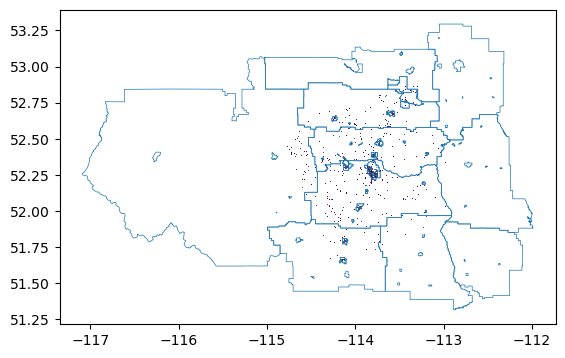

In [41]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## Red Deer area geoemtry
nearby_speeds = speed_tiles.sjoin(reddeer_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)


In [42]:
subdiv_pops = statcan.census_subdivisions_populations()
subdiv_pops.DAPOP = pd.to_numeric(subdiv_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
subdiv_pops

/home/jovyan/src/datasets/loading/statcan.py:104: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(POP_FILE)


,CSDUID,GEO_NAME,DAPOP
381,1001105,"Portugal Cove South, T",150.0
635,1001113,"Trepassey, T",485.0
1016,1001120,"St. Shott's, T",65.0
1270,1001124,"Division No. 1, Subd. U, SNO",1625.0
1778,1001126,"Cape Broyle, T",490.0
...,...,...,...
7605014,6208047,"Kugaaruk, HAM",935.0
7605268,6208059,"Kugluktuk, HAM",1490.0
7605649,6208073,"Cambridge Bay, HAM",1770.0
7606157,6208081,"Gjoa Haven, HAM",1325.0


<AxesSubplot: >

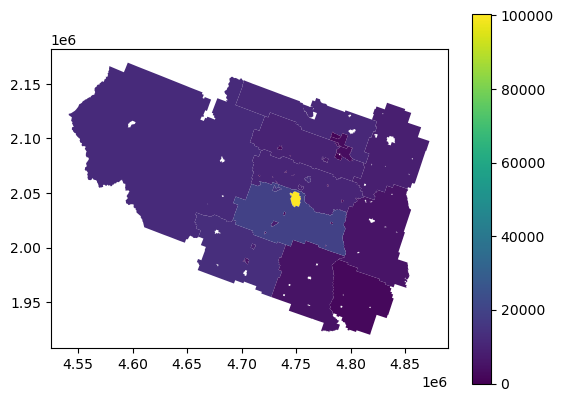

In [43]:
nearby_census_subdivs.CSDUID = nearby_census_subdivs.CSDUID.astype(int) ## coerce ID type to fully int instead of object
nearby_census_subdivs.merge(subdiv_pops, on='CSDUID', validate='1:1').plot(column='DAPOP', vmin=0, categorical=False, legend=True)